# Example: Roomba Lava World Task using Q-Learning
You have a [roomba](https://www.irobot.com) that has finished cleaning the kitchen floor and needs to return to its charging station. However, between your kitchen floor and the `charging station` (safety), there are one or more `lava pits` (destruction for the [roomba](https://www.irobot.com)). 
* This is an example of a two-dimensional grid-world navigational decision task that will familiarize students with using `Q-learning` for solving a two-dimensional grid-world navigation task, the role of the discount factor $\gamma$, the learning rate $\alpha$, the fraction of exploration $\epsilon$, as well as more advanced topics such as [Reward shaping](https://gibberblot.github.io/rl-notes/single-agent/reward-shaping.htmlhttps://gibberblot.github.io/rl-notes/single-agent/reward-shaping.html).

### Background
In the `Q-learning` approach, we estimate the $Q(s,a)$ function through experimentation, where we update $Q(s,a)$ after each experiment using the update rule:

$$
\begin{equation*}
Q(s,a)\leftarrow{Q(s,a)}+\alpha\cdot\left(r+\gamma\cdot\max_{a^{\prime}}Q(s^{\prime},a^{\prime}) - Q(s,a)\right)
\end{equation*}
$$

The quantity $\alpha$ is the learning rate parameter, $r$ is the reward, $\gamma$ is the discount factor, $s^{\prime}$ and $a^{\prime}$ 
are the next state and action, respectively. Once we have the $Q(s, a)$ function, we can estimate the policy $\pi(s)$:

$$
\begin{equation*}
\pi(s) = \arg\max_{a}Q(s,a)
\end{equation*}
$$

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [3]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-15/L15a/Manifest.toml`


In [4]:
function rbf(x::Tuple{Int,Int},y::Tuple{Int,Int}; σ = 1.0)::Float64
    d = sqrt((x[1] - y[1])^2 + (x[2] - y[2])^2);
    return exp(-d/(2*σ^2))
end;

## Task 1: Build the Rectangular Grid World Model
We encode the `rectangular grid world` using the `MyRectangularGridWorldModel` model, which we construct using a `build(...)` method. Let's set up the data for the `apples` and `oranges` world, i.e., set up the states, actions, and rewards and then construct the world model. 
* First, set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` available to the agent, and the `discount factor` $\gamma$. Then, we compute the number of states and set up the state set $\mathcal{S}$ and the action set $\mathcal{A}$

In [6]:
# Step 1: Build a model of the world -
number_of_rows = 30
number_of_cols = 30
nactions = 4; 
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;

Next, set up a description of the rewards, the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. In a `MDP` this will be visible to the agent, however, in `Q-learning` the rewards (and physics) are features of the world model, and are unknown to the agent.
  * First, let's formulate the `terminal states`, e.g., the location of the `charging station`, the `lava pits` and any other constraints such as `softwalls` (not terminal, states but locations to avoid). Set the reward for these states according to thier identity.
  * Next, add the `terminal states` to the `absorbing_state_set`

In [8]:
# setup rewards -
lava_reward = -1000.0;
charging_reward = 100.0;
softwall_reward = -2000.0;
σ = 1.0;
default_reward = -1.0;

# setup rewards -
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(5,5)] =  lava_reward # lava in the (5,5) square 
rewards[(6,5)] = lava_reward # lava in the (6,5) square
rewards[(6,6)] = lava_reward # lava in the (6,6) square
rewards[(5,6)] = charging_reward    # charging station square

# walls?
soft_wall_set = Set{Tuple{Int,Int}}();
push!(soft_wall_set, (2,1));
push!(soft_wall_set, (2,2));
push!(soft_wall_set, (2,3));
push!(soft_wall_set, (7,4));
push!(soft_wall_set, (4,6));
for s in soft_wall_set
    rewards[s] = softwall_reward;
end

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
for (k,v) ∈ rewards
    push!(absorbing_state_set, k);   
end

### Reward shaping
In cases where rewards are sparse, there are few $(s,a)$ pairs that lead to non-zero rewards. This is an issue because reinforcement learning algorithms, e.g., `Q-learning` behave randomly initially when the action-value function $Q(s,a)$ is unknown. 

* [Reward shaping](https://gibberblot.github.io/rl-notes/single-agent/reward-shaping.htmlhttps://gibberblot.github.io/rl-notes/single-agent/reward-shaping.html) is an approach to address this issue, by modifying the reward function to promote behavior that we think will move us closer to the goal state, e.g., the `charging_station`. There are different approaches to this. We'll use a [radial basis kernel function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) to distribute charging station rewards radially from the goal state.

In [10]:
# do some shaping?
is_reward_shaping_on = true;
if (is_reward_shaping_on == true)
    for s in 𝒮
        for s′ in 𝒮
            coordinate = (s,s′);
            if (haskey(rewards, coordinate) == false && in(coordinate,soft_wall_set) == false && 
                    in(coordinate,absorbing_state_set) == false)
                rewards[coordinate] = default_reward + charging_reward*rbf(coordinate, (5,6), σ = σ);
            end
        end
    end
end

Finally, build an instance of the `MyRectangularGridWorldModel` type, which models the grid world. We save this instance in the `world_model` variable
* Pass in the number of rows `nrows`, number of cols `ncols`, and our initial reward description in the `rewards` field into the `build(...)` method

In [12]:
# call the factory -
world_model = build(MyRectangularGridWorldModel, (
        nrows=number_of_rows, ncols=number_of_cols, rewards = rewards, defaultreward = default_reward));

## Task 2: Build the Q-learning agent
We build an agent model, i.e., the code representation of the [roomba](https://www.irobot.com) using the `MyQLearningAgentModel` type encoded in the [Types.jl file](src/Types.jl) and an associated `build` function encoded in the [Factory.jl file](src/Factory.jl).
* The learning rate parameter `α` describes the weight of the update step (how we incorporate new information), while the discount rate `γ` is the weight of future steps. In this example, we initialize `Q` to a matrix of zeros.

In [14]:
#α = 0.7;  # learning rate
α = 0.0;  # learning rate
γ = 0.95; # discount rate
nstates = (number_of_rows*number_of_cols);
agent_model = build(MyQLearningAgentModel, (
    states = 𝒮,
    actions = 𝒜,
    α = α,
    γ = γ,
    Q = zeros(nstates,nactions) # Hmmm. Could we do something better that this?
));

## Task 3: Simulate and visualize
To begin, set the initial location in the `startstate` variable, the number of times we want the agent to perform the task in the `number_of_episodes` variable, and the number of steps that the agent takes in the `number_of_iterations` variable:

In [16]:
startstate = (30,1); # start position
number_of_episodes = 200; # how many times do we repeat the task?
number_of_iterations = 1000; # problem horizon (how many moves)

Next, we allow the agent to experiment with the world. In the simulation loop, we start with an initial `Q` table and ask the agent to repeat the same task `number_of_episodes` times, where each episode contains `number_of_iterations` steps. After each episode, we reset the `Q` table on the agent to the value obtained from the episode and perform the task again.

In [18]:
my_Q_dictionary = Dict{Tuple{Int,Int}, Array{Float64,2}}();
coordinate = startstate;
for i ∈ 1:number_of_episodes
    
    # run an episode, and grab the Q
    result = simulate(agent_model, world_model, coordinate, number_of_iterations, ϵ = 0.7);

    # update the agent with the Q from the last episode, and try to refine this Q
    # Analogy: practice make perfect ...
    agent_model.Q = result.Q;
end
my_Q_dictionary[coordinate] = agent_model.Q;

We can now build the policy $\pi$ function from the `Q` table. We iterate through each state $s\in\mathcal{S}$ and select the action $a\in\mathcal{A}$ that gives the highest utility. We've implemented this logic in the [policy function](src/Compute.jl), which takes the `Q` table as its only argument:

In [20]:
Q = my_Q_dictionary[startstate];
my_π = policy(Q);

`Unhide` the code block below to see how we plot the path through our grid world that [roomba](https://www.irobot.com/en_US/roomba.html?source=google_paid&medium=cpc&ds_campaign=US+-+Conversion+-+Brand+-+SEM+-+Roomba+-+Core+-+Exact&ds_content=Core+-+Roomba+-+Exact&ds_keyword=roomba&gad_source=1&gclid=EAIaIQobChMIu_65qsfYhQMVImJHAR3i1wTGEAAYASAAEgKwgfD_BwE&gclsrc=aw.ds) uses to get back to the charging station (shown as the green circle) while navigating around the lava pits (should as red circles).

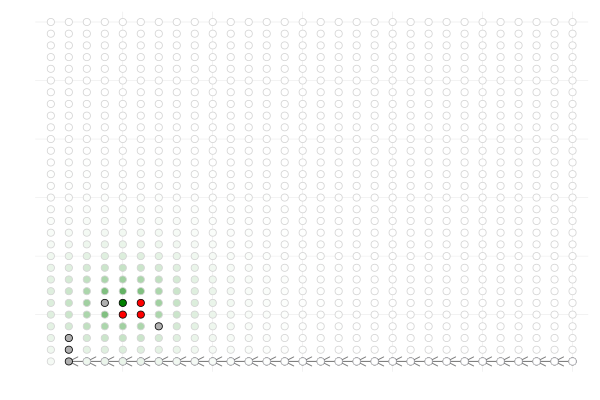

In [22]:
# draw the path -
p = plot();
initial_site = startstate
hit_absorbing_state = false
s = world_model.states[initial_site];
visited_sites = Set{Tuple{Int,Int}}();
push!(visited_sites, initial_site);

while (hit_absorbing_state == false)
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
    plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=1, c=:gray)
    
    if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
        hit_absorbing_state = true;
    elseif (haskey(world_model.states, new_position) == true)
        s = world_model.states[new_position];
        push!(visited_sites, new_position);
    else
        hit_absorbing_state = true; # we drove off the map
    end
end

# draw the grid -
for s ∈ 𝒮
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    
    if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=4)
    elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=4)
    elseif (in(current_position, soft_wall_set) == true)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
    else
        if (is_reward_shaping_on == true)
            new_color = weighted_color_mean(rbf(current_position, (5,6), σ = σ), colorant"green", colorant"white")
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:lightgray, c=new_color)
        else
            scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
        end
    end
end
current()